## Carga de datos

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

sns.set_style("whitegrid")
figsize = (14, 7)

raw = pd.read_excel("datos/datos-de-prueba.xlsx", sheet_name=None)

In [2]:
def format_raw(raw, key):
    data = raw[key].groupby(['Material', 'Fe.contabilización']).sum().loc[:, 'Cantidad +']
    col = data.index.levels[0]
    idx = data.index.levels[1]
    return pd.DataFrame(data=data.values, columns=col, index=idx)

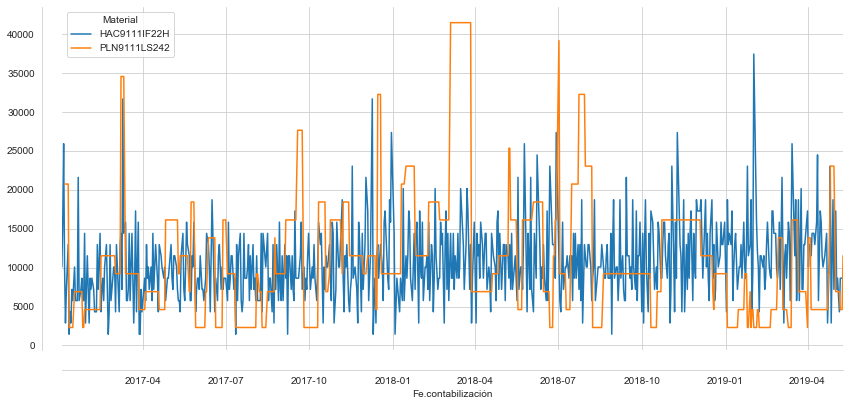

In [3]:
full = pd.concat([format_raw(raw, '200 helix'), format_raw(raw, 'Planteur stick')], 1).ffill()
full.plot(figsize=(14, 7))
sns.despine(offset=20)

In [4]:
data = raw['glc'].groupby(['Material', 'Fe.contabilización']).sum().loc[:, 'Cantidad +']
col = data.index.levels[0]
idx = data.index.levels[1]

In [5]:
data.to_frame()

Cantidad +
Material     Fe.contabilización            
GLC9312SF211 43595                    40320
GLC9312SF212 42753                    28500
             42912                     5700
             42913                    11400
             42914                    11400
             42975                    28500
             43056                    28500
             43136                    28500
             43187                    28212
             43258                    28500
             43297                    28500
             43406                    28500
             43445                    28500
             43543                    28500
             43566                    28500

Como vemos, de los datos que nos han pasado:
 - Solamente dos de tres series tiene una calidad del dato decente.
 - De estas dos, apenas una tiene datos completos, pues uno de los materiales (que indican las cápsulas de café) tiene muchos huecos por lo que se intuye que simplemente este material se demanda con mucha más distancia entre pedido y pedido.

## Exploración de datos

Vamos a hacer Data Research sobre la serie que tiene una buena cantidad de datos.

In [6]:
serie = full.iloc[:, 0]

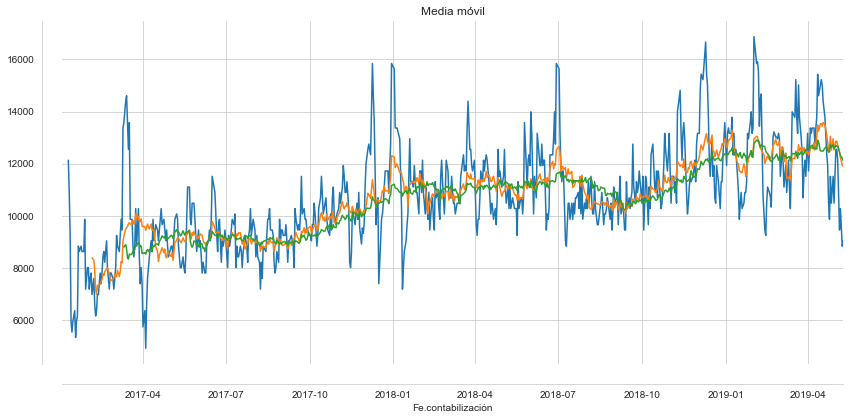

In [7]:
for days in [7, 30, 60]:
    serie.rolling(days).mean().plot(title="Media móvil", figsize=figsize)
    sns.despine(offset=20)

La serie tiene una marcada tendencia por lo que habrá que desestacionalizarla con al menos una diferencia si nos decantamos por usar modelos ARIMA.

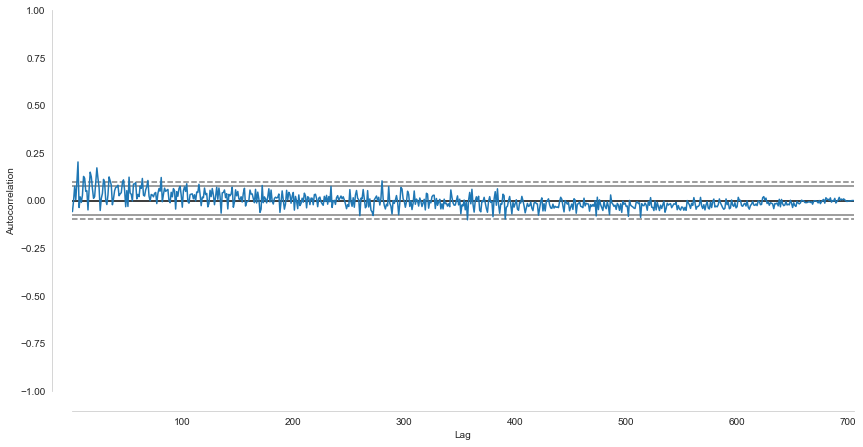

In [8]:
from pandas.plotting import autocorrelation_plot

plt.figure(figsize=figsize)
autocorrelation_plot(serie)
sns.despine(offset=20)

Por otro lado tiene bastante poca autocorrelación con los lags anteriores. Tampoco hay marcadas estacionalidades. De todos modos hay que comprobarlo con mapas de calor.

In [9]:
featured = serie.copy().to_frame()
featured['week_of_year'] = serie.index.week
featured['day_of_month'] = serie.index.day
featured['day_of_week'] = serie.index.dayofweek
featured['month'] = serie.index.month
featured['quarter'] = serie.index.quarter
featured['week_of_month'] = pd.Series(serie.index).apply(lambda d: (d.day-1) // 7 + 1).values

In [10]:
def plot_heatmap(x, y):
    aux = featured.pivot_table(index=x, columns=y, values=serie.name, aggfunc=np.mean)
    return sns.heatmap(aux)

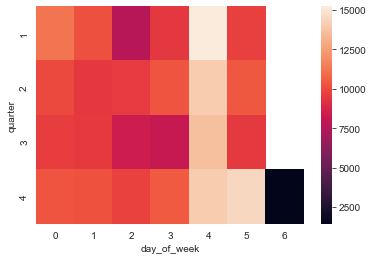

In [11]:
plot_heatmap('quarter', 'day_of_week')

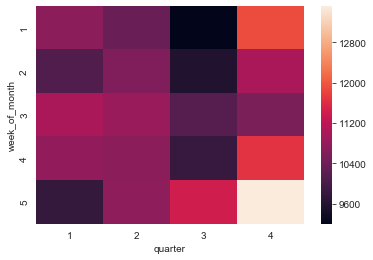

In [12]:
plot_heatmap('week_of_month', 'quarter')

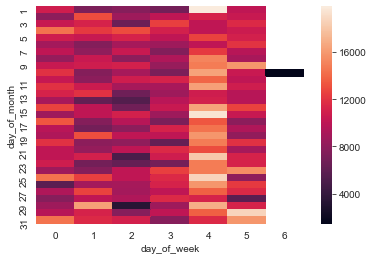

In [13]:
plot_heatmap('day_of_month', 'day_of_week')

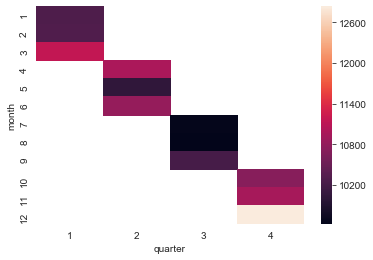

In [14]:
plot_heatmap('month', 'quarter')

Destaca que se hacen más pedidos los viernes y en el último trimestre del año.

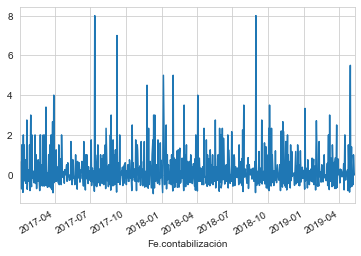

In [37]:
serie.pct_change().plot()

## Modelado

Vamos a lanzar un modelo de Prophet sencillo que es el mismo que estaríamos usando en la preview de AWS Forecast.

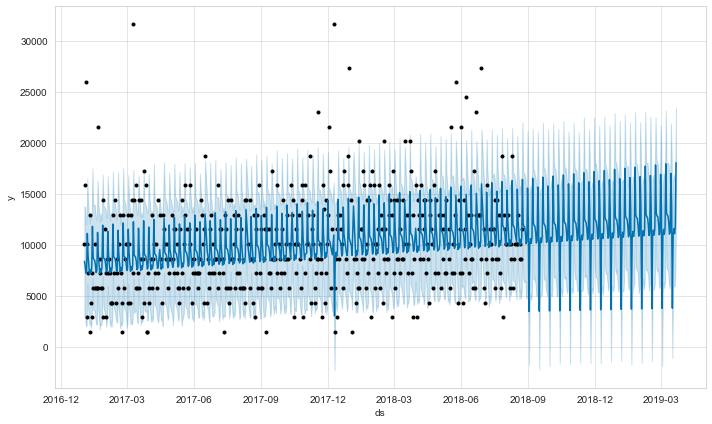

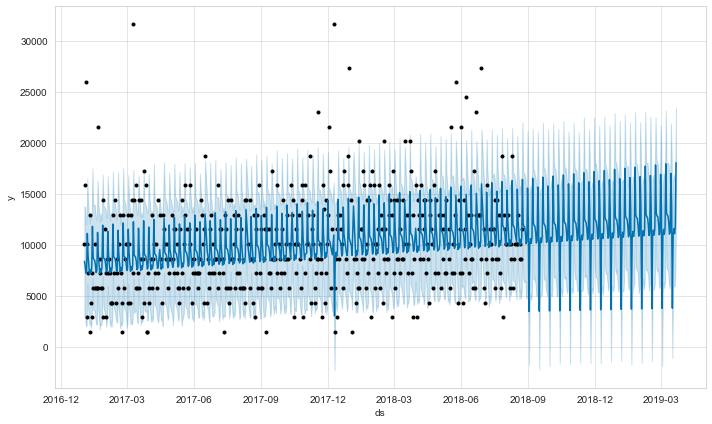

In [110]:
from fbprophet import Prophet

test_size = 0.3

data = serie.reset_index().rename(columns={'Fe.contabilización': 'ds', serie.name: 'y'})
train = data.iloc[:int(np.floor((1 - test_size) * data.shape[0])), :]
test = data.iloc[int(np.floor((1 - test_size) * data.shape[0])) + 1 :, :]

model = Prophet(yearly_seasonality=False, 
                weekly_seasonality=False, 
                daily_seasonality=False, 
                seasonality_mode='additive')
model.add_seasonality('weekly', period=14, fourier_order=30, mode='multiplicative')
# model.add_seasonality('monthly', period=12, fourier_order=5, mode='multiplicative')
model.fit(train)
future = model.make_future_dataframe(periods=test.shape[0])
forecast = model.predict(future)
model.plot(forecast)

Como vemos, el modelo de Prophet no predice muy bien para este conjunto de datos.

Vamos a probar ahora con Random Forest.

In [139]:
from sklearn.ensemble import RandomForestRegressor

test_size = 0.2

data = featured.copy()
train = data.iloc[:int(np.floor((1 - test_size) * data.shape[0])), :]
test = data.iloc[int(np.floor((1 - test_size) * data.shape[0])) + 1 :, :]

X_train = train.iloc[:, 1:]
Y_train = train.iloc[:, 0]

X_test = test.iloc[:, 1:]
Y_test = test.iloc[:, 0]

In [140]:
model = RandomForestRegressor(n_estimators=100)
model.fit(X_train, Y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [141]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [142]:
Y_hat = model.predict(X_train)

In [143]:
print("El MAPE de un Random Forest es de {:.2f}%".format(mean_absolute_percentage_error(Y_train, Y_hat)))

El MAPE de un Random Forest es de 20.59%


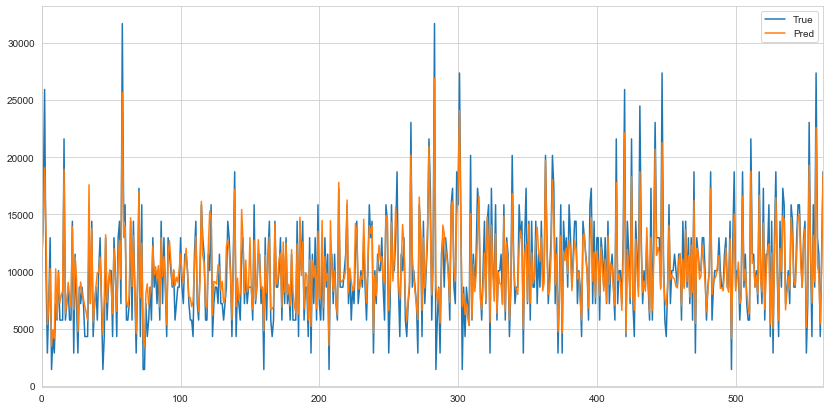

In [144]:
pd.DataFrame(np.vstack((Y_train, Y_hat))).T.rename(columns={0: "True", 1:"Pred"}).plot(figsize=figsize)

In [145]:
Y_pred = model.predict(X_test)

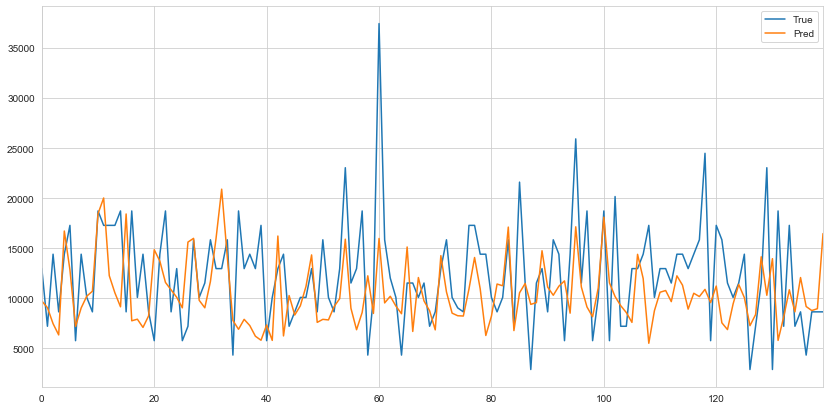

In [146]:
pd.DataFrame(np.vstack((Y_test, Y_pred))).T.rename(columns={0: "True", 1:"Pred"}).plot(figsize=figsize)

In [147]:
print("El MAPE de un Random Forest es de {:.2f}%".format(mean_absolute_percentage_error(Y_test, Y_pred)))

El MAPE de un Random Forest es de 38.72%


Con este modelo de Random Forest tenemos buen score en train pero no en test, estamos haciendo overfit y es que la falta de longitud de la serie hace que la capacidad del algoritmo sea excesiva en relación a la cantidad de datos de los que disponemos. Por tanto tenemos varias opciones:
 - Incrementar la longitud de la serie, que no podemos
 - Incrementar el número de features